<a href="https://colab.research.google.com/github/PXDHU/Natural-Language-Processing/blob/main/Predicting_the_next_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicting the next word**

Creating a model that will predict the next word in a text sequence and train it using a corpus of Shakespeare's sonnets, while also creating some helper functions to pre-process the data.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

Dataset:[Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [ ]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 120MB/s]


In [ ]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

Fitting the Tokenizer to the corpus and save the total number of words.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [ ]:
corpus[0]

'from fairest creatures we desire increase,'

This text directly into the `texts_to_sequences` method will get an unexpected result:

In [ ]:
tokenizer.texts_to_sequences(corpus[0])

[[],
 [],
 [58],
 [],
 [],
 [],
 [17],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 []]

This happened because `texts_to_sequences` expects a list and we are providing a string. However a string is still and `iterable` in Python so you will get the word index of every character in the string.

Instead we need to place the example whithin a list before passing it to the method:

In [ ]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

In [ ]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

## Generating n_grams

This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus:

In [ ]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]

      for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
            
    return input_sequences

In [ ]:
# Testing with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [ ]:
# Testing with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

Applying the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [ ]:
# grader-required-cell

# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences
The `pad_seqs` function which will pad any given sequences to the desired maximum length. This function receives a list of sequences and should return a numpy array with the padded sequences: 

In [ ]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
   
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')
    
    return padded_sequences

In [ ]:
# Testing function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [ ]:
# Testing function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [ ]:
# Padding the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Split the data into features and labels
This function expects the padded n_gram sequences as input and should return a tuple containing the features and the one hot encoded labels.

In [ ]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [ ]:
# Testing function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [ ]:
# Splitting the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Creating the model

Model architecture capable of achieving an accuracy of at least 80%.

- An appropriate `output_dim` for the first layer (Embedding) is 100.
- A Bidirectional LSTM 
- The last layer with the same number of units as the total number of words in the corpus and a softmax activation function.
- Only two layers (excluding the Embedding),just small architectures first.

In [ ]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1)),
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation = 'softmax'))


    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
# Trainiing the model
model = create_model(total_words, max_sequence_len)
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 24s 30ms/step - loss: 6.8840 - accuracy: 0.0227
Epoch 2/50
484/484 [==============================] - 5s 11ms/step - loss: 6.4265 - accuracy: 0.0320
Epoch 3/50
484/484 [==============================] - 4s 9ms/step - loss: 6.1963 - accuracy: 0.0407
Epoch 4/50
484/484 [==============================] - 5s 11ms/step - loss: 5.9619 - accuracy: 0.0475
Epoch 5/50
484/484 [==============================] - 4s 8ms/step - loss: 5.6805 - accuracy: 0.0595
Epoch 6/50
484/484 [==============================] - 4s 8ms/step - loss: 5.3456 - accuracy: 0.0716
Epoch 7/50
484/484 [==============================] - 5s 11ms/step - loss: 4.9645 - accuracy: 0.0891
Epoch 8/50
484/484 [==============================] - 5s 11ms/step - loss: 4.5568 - accuracy: 0.1166
Epoch 9/50
484/484 [==============================] - 6s 12ms/step - loss: 4.1455 - accuracy: 0.1618
Epoch 10/50
484/484 [==============================] - 4s 9ms/step - loss: 3.7530 - accuracy:

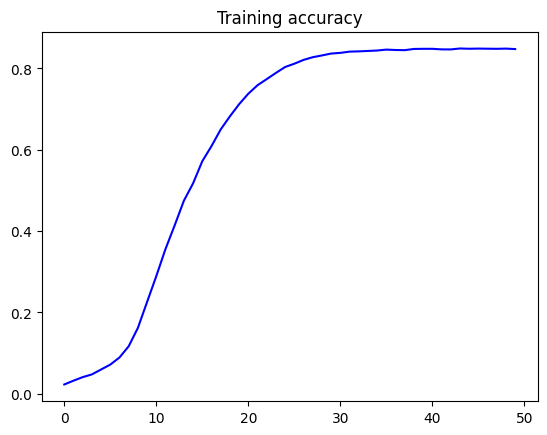

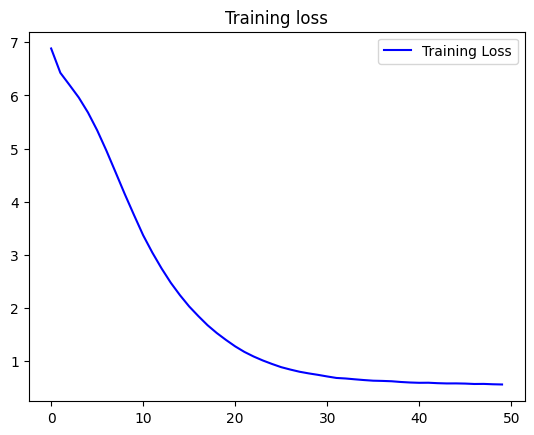

In [ ]:
# Training curves

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## Model in action

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    # Converting the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Padding the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Getting the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Appending to the current text
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope then my argument more too still to die to prove each wit prove ' forth loss of thee do have more more new still new spent fickle worth poison dumb that best stol'n is it contains friend still me untrue well her such place of thine hate doth call it ' not skill fair lovest hate so lark lovest is hate to time's edge that brought to time's part ' leave thee eye prove good his telling heart taken taken thee back the second state of her minds to the sun day by day lie to me do bred friend
